In [ ]:
!pip install PyPortfolioOpt
!pip install kaleido
!pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.9 MB/s eta 0:00:00


In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
from pandas_datareader.data import DataReader
import datetime
import calendar
from pypfopt.expected_returns import ema_historical_return
from pypfopt.risk_models import CovarianceShrinkage
import cvxpy as cp
import plotly.express as px
import plotly.graph_objects as go
import urllib.request
import json

In [ ]:
#get S&P 500 tickers from wikipedia table
wiki = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
first_table = wiki[0]
second_table = wiki[1]

#keep tickers that were first added before 1/1/2016 and randomly select 50
df = first_table
df_date_filter = df[df['Date added'] < '2019-01'].copy()
tickers = df_date_filter.sample(n=50, random_state=1804)['Symbol'].to_list()

In [ ]:
#lists for saving the historical esg scores for each ticker, and missing list in case data are missing for a ticker
esg_list = []
e_list = []
s_list = []
g_list = []
missing = []

for ticker in tickers:

    try:
        url = "https://query2.finance.yahoo.com/v1/finance/esgChart?symbol={}".format(ticker)

        connection = urllib.request.urlopen(url)

        data_connection = connection.read()
        data_json = json.loads(data_connection)
        formatdata = data_json["esgChart"]["result"][0]["symbolSeries"]
        df_data = pd.DataFrame(formatdata)
        df_data["timestamp"] = pd.to_datetime(df_data["timestamp"], unit="s")
        df_data = df_data.set_index('timestamp')
        # get years from 2017 to 2019
        df_data = df_data.loc['2017':'2019']
        esg_list.append(df_data['esgScore'])
        e_list.append(df_data['environmentScore'])
        s_list.append(df_data['socialScore'])
        g_list.append(df_data['governanceScore'])
    except:
        missing.append(ticker)
        continue

# If ticker is missing data remove ticker from investment sample universe
if missing != None:
    for tick in missing:
        tickers.remove(tick)

esg_df = pd.concat(esg_list, axis=1)
esg_df.columns = tickers

e_df = pd.concat(e_list, axis=1)
e_df.columns = tickers

s_df = pd.concat(s_list, axis=1)
s_df.columns = tickers

g_df = pd.concat(g_list, axis=1)
g_df.columns = tickers

In [ ]:
esg_df

,IPG,CNP,GOOGL,AMZN,DTE,DLTR,HAS,COP,XEL,KO,...,PPG,NOC,ROL,ARE,EXPD,CCL,CPRT,SPG,AMAT,BALL
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01,56.16,53.24,63.38,49.61,66.18,51.57,64.37,69.31,75.67,62.99,...,69.17,66.23,45.53,56.01,51.76,60.60,43.69,50.60,64.33,NaN
2017-02-01,56.16,53.24,63.38,49.61,66.18,51.57,64.37,69.31,75.67,62.99,...,69.17,66.23,45.53,56.01,51.76,60.60,43.69,50.60,64.33,NaN
2017-03-01,56.16,53.24,63.38,49.61,66.18,51.57,64.37,69.31,75.67,62.99,...,69.17,66.23,48.10,56.01,51.76,60.60,43.69,50.60,64.33,NaN
2017-04-01,56.16,53.24,64.13,49.61,66.18,51.57,64.37,69.31,75.67,62.99,...,69.17,66.00,48.10,56.01,51.76,60.60,42.84,50.60,64.33,NaN
2017-05-01,55.96,53.24,63.38,49.61,66.98,51.19,64.50,69.18,75.40,62.86,...,69.17,65.78,48.10,55.26,51.76,60.60,42.84,50.60,64.88,NaN
2017-06-01,55.96,53.24,63.38,49.61,66.98,51.19,64.50,69.18,75.40,62.86,...,69.17,65.78,48.10,55.26,51.76,60.60,42.84,50.60,64.88,NaN
2017-07-01,55.96,53.24,63.38,49.61,66.98,51.57,64.50,69.18,75.40,62.86,...,69.17,65.78,48.10,55.26,51.76,60.60,42.84,50.60,64.88,NaN
2017-08-01,55.96,53.24,62.79,47.32,66.98,49.54,64.50,72.75,75.40,62.86,...,67.12,65.78,48.10,57.23,51.76,60.60,42.84,57.68,64.88,NaN
2017-09-01,55.96,53.28,62.79,47.32,68.84,49.54,64.50,72.75,73.25,62.86,...,67.12,65.78,48.10,57.23,51.76,60.60,42.84,57.68,64.88,NaN


<Axes: ylabel='Frequency'>

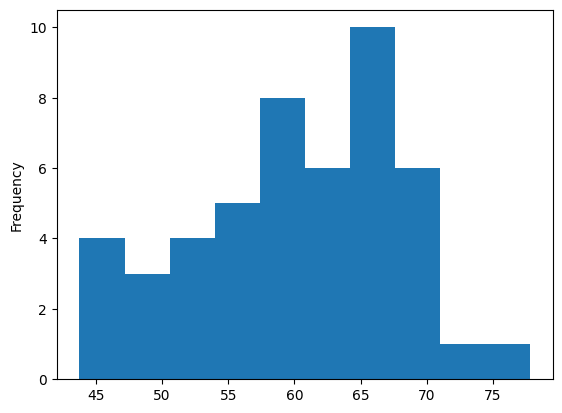

In [ ]:
#plot distribution of ESG scores for investment sample universe
esg_df.mean().plot(kind='hist')

In [ ]:
import yfinance as yf
import pandas as pd
import datetime
import calendar


year_start = esg_df.index.min().year
month_start = esg_df.index.min().month
year_end = esg_df.index.max().year
month_end = esg_df.index.max().month
last_day_date = calendar.monthrange(year_end, month_end)[1]

start = datetime.date(year_start, month_start, 1)
end = datetime.date(year_end, month_end, last_day_date)

def get_stocks(tickers, start, end):
    stocks_list = []
    for ticker in tickers:
        try:
            stock_data = yf.download(ticker, start=start, end=end)
            if stock_data.empty:
                continue
            stocks_list.append(stock_data['Close'].rename(ticker))
        except Exception as e:
            print(f"Failed to fetch data for ticker: {ticker}. Error: {e}")
            continue

    if len(stocks_list) > 0:
        all_stocks = pd.concat(stocks_list, axis=1)
        return all_stocks
    else:
        return pd.DataFrame()


stocks = get_stocks(tickers, start, end)
clean_ticks = [x.split('_')[1] if '_' in x else x for x in stocks.columns]
stocks.columns = clean_ticks


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [ ]:
print(stocks.columns)

Index(['IPG', 'CNP', 'GOOGL', 'AMZN', 'DTE', 'DLTR', 'HAS', 'COP', 'XEL', 'KO',
       'CMS', 'DFS', 'NI', 'GE', 'ADP', 'FITB', 'INCY', 'HRL', 'ALL', 'KHC',
       'PEP', 'COST', 'IRM', 'QCOM', 'BXP', 'MCHP', 'CI', 'PM', 'RCL', 'NTAP',
       'ITW', 'DVN', 'ORCL', 'CNC', 'EBAY', 'MTD', 'CAH', 'BKNG', 'RSG', 'PPG',
       'NOC', 'ROL', 'ARE', 'EXPD', 'CCL', 'CPRT', 'SPG', 'AMAT', 'BALL'],
      dtype='object')


In [ ]:
stocks.head()

,IPG,CNP,GOOGL,AMZN,DTE,DLTR,HAS,COP,XEL,KO,...,PPG,NOC,ROL,ARE,EXPD,CCL,CPRT,SPG,AMAT,BALL
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,23.510000,24.590000,40.400501,37.683498,83.582977,77.449997,79.800003,50.610001,40.619999,41.799999,...,95.250000,234.889999,14.884444,110.580002,53.099998,52.139999,6.96500,182.619995,31.940001,37.875000
2017-01-04,23.629999,24.809999,40.388500,37.859001,83.804253,79.449997,80.940002,51.080002,40.799999,41.650002,...,97.269997,235.250000,15.017778,113.379997,53.150002,52.820000,7.05750,184.080002,32.240002,38.450001
2017-01-05,23.100000,24.809999,40.651001,39.022499,83.914894,78.059998,83.709999,50.930000,40.799999,41.750000,...,95.620003,235.990005,14.942222,112.970001,53.029999,53.709999,7.05000,184.399994,32.099998,38.430000
2017-01-06,23.639999,25.360001,41.260502,39.799500,84.136169,77.089996,82.870003,50.740002,40.919998,41.740002,...,95.589996,236.729996,14.862222,112.209999,53.130001,53.650002,7.08500,186.830002,32.040001,38.599998
2017-01-09,23.510000,24.879999,41.359001,39.846001,83.302132,77.139999,82.599998,49.660000,40.299999,41.320000,...,96.349998,235.809998,14.724444,111.050003,53.040001,53.689999,7.06625,185.910004,32.779999,37.990002


In [ ]:
#subsets creation

esg_tot_sample = esg_df[clean_ticks].copy()
esg_e_sample = e_df[clean_ticks].copy()
esg_s_sample = s_df[clean_ticks].copy()
esg_g_sample = g_df[clean_ticks].copy()

In [ ]:
s_df

,IPG,CNP,GOOGL,AMZN,DTE,DLTR,HAS,COP,XEL,KO,...,PPG,NOC,ROL,ARE,EXPD,CCL,CPRT,SPG,AMAT,BALL
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01,46.89,61.00,63.30,50.49,74.86,45.41,67.71,76.33,80.19,64.55,...,70.61,61.39,45.27,38.58,39.86,60.43,40.00,51.43,65.64,NaN
2017-02-01,46.89,61.00,63.30,50.49,74.86,45.41,67.71,76.33,80.19,64.55,...,70.61,61.39,45.27,38.58,39.86,60.43,40.00,51.43,65.64,NaN
2017-03-01,46.89,61.00,63.30,50.49,74.86,45.41,67.71,76.33,80.19,64.55,...,70.61,61.39,48.33,38.58,39.86,60.43,40.00,51.43,65.64,NaN
2017-04-01,46.89,61.00,63.30,50.49,74.86,45.41,67.71,76.33,80.19,64.55,...,70.61,55.14,48.33,38.58,39.86,60.43,40.00,51.43,65.64,NaN
2017-05-01,46.89,61.00,63.30,50.49,74.86,44.46,67.71,76.33,80.19,64.55,...,70.61,55.14,48.33,38.58,39.86,60.43,40.00,51.43,65.64,NaN
2017-06-01,46.89,61.00,63.30,50.49,74.86,44.46,67.71,76.33,80.19,64.55,...,70.61,55.14,48.33,38.58,39.86,60.43,40.00,51.43,65.64,NaN
2017-07-01,46.89,61.00,63.30,50.49,74.86,45.41,67.71,76.33,80.19,64.55,...,70.61,55.14,48.33,38.58,39.86,60.43,40.00,51.43,65.64,NaN
2017-08-01,46.89,61.00,61.98,47.64,74.86,44.46,67.71,84.48,80.19,64.55,...,70.33,55.14,48.33,38.58,39.86,60.43,40.00,56.74,65.64,NaN
2017-09-01,46.89,61.14,61.98,47.64,75.91,44.46,67.71,84.48,81.69,64.55,...,70.33,55.14,48.33,38.58,39.86,60.43,40.00,56.74,65.64,NaN


In [ ]:
#EF -> highest expected return for any given level of risk
#calculating the expected return (mu) and the covariance matrix (s) and optimizing


# Function for optimization and computing efficient frontier
class efficient_frontier():
    def __init__(self, stocks, up_bound, samples, ticks):
        self.stocks = stocks
        self.upper_bound = up_bound
        self.samples = samples
        self.ticks = ticks

    # Optimization
    def optimize_portfolios(self):
        # Compute exponentially weighted historical mean returns
        mu = ema_historical_return(self.stocks)
        # Compute covariance matrix using ledoit-wolf shrinkage
        s = CovarianceShrinkage(self.stocks).ledoit_wolf()
        n = len(mu)
        # Set upper bound for weights
        upper_bound = self.upper_bound
        w = cp.Variable(n)
        gamma = cp.Parameter(nonneg=True)
        ret = mu.to_numpy().T@w
        risk = cp.quad_form(w, s.to_numpy())
        # Utility function to optimize
        prob = cp.Problem(cp.Maximize(ret - gamma*risk),
                          [cp.sum(w) == 1, w >= 0, w <= upper_bound])

        risk_data = np.zeros(self.samples)
        ret_data = np.zeros(self.samples)
        weights_data = []
        # Gamma variables for utility function
        gamma_vals = np.logspace(-2, 3, num=self.samples)

        for i in range(self.samples):
            gamma.value = gamma_vals[i]
            prob.solve()
            weights = w
            weights_tick = pd.Series(weights.value, index=self.ticks)
            weights_tick_filter = weights_tick[weights_tick > 1.0e-03]
            weights_data.append(weights_tick_filter)
            risk_data[i] = cp.sqrt(risk).value
            ret_data[i] = ret.value
        # DataFrame with weights of stocks
        weights_df = pd.concat(weights_data, axis = 1).T.fillna(0)
        # DataFrame with returns and risk
        rr_df = pd.DataFrame({'Return': ret_data, 'Risk': risk_data})
        self.portfolios_df = pd.concat([rr_df, weights_df], axis = 1)

![Alt text](https://i.imgur.com/OulXvMs.jpeg)


In [ ]:
#No Screen
conv_frontier = efficient_frontier(stocks, 0.05, 200, clean_ticks)
conv_frontier.optimize_portfolios()

In [ ]:
#ESG screening function
#taking the 30th percentile of these mean ESG scores.
#function takes two data frames as input: esg_df, which contains ESG scores for various stocks, and stocks_df, which contains stock data. It first calculates the mean ESG score for each stock in esg_df
#it then determines a threshold value by taking the 30th percentile of these mean ESG scores

def screen(esg_df, stocks_df):
    mean_esg = esg_df.mean()
    thresh = mean_esg.quantile(0.3)
    mean_esg = mean_esg[mean_esg > thresh]
    screen_stocks = stocks_df[mean_esg.index]
    screen_ticks = screen_stocks.columns
    return screen_stocks, screen_ticks

In [ ]:
#for each screened subset of stocks calculate the efficient frontier using the efficient_frontier function
#calculate optimal portfolio based on a risk-return trade-off, given a target return rate (0.05) and a number of portfolios to consider (200)

# E Screen
e_stocks, e_ticks = screen(esg_e_sample, stocks)
e_frontier = efficient_frontier(e_stocks, 0.05, 200, e_ticks)
e_frontier.optimize_portfolios()

# S Screen
s_stocks, s_ticks = screen(esg_s_sample, stocks)
s_frontier = efficient_frontier(s_stocks, 0.05, 200, s_ticks)
s_frontier.optimize_portfolios()

# G Screen
g_stocks, g_ticks = screen(esg_g_sample, stocks)
g_frontier = efficient_frontier(g_stocks, 0.05, 200, g_ticks)
g_frontier.optimize_portfolios()

# ESG Screen
esg_stocks, esg_ticks = screen(esg_tot_sample, stocks)
esg_frontier = efficient_frontier(esg_stocks, 0.05, 200, esg_ticks)
esg_frontier.optimize_portfolios()

In [ ]:
rr_conv = conv_frontier.portfolios_df[['Return', 'Risk']].copy()
rr_conv['Screen'] = 'No ESG Constraints'

rr_e = e_frontier.portfolios_df[['Return', 'Risk']].copy()
rr_e['Screen'] = 'E'

rr_s = s_frontier.portfolios_df[['Return', 'Risk']].copy()
rr_s['Screen'] = 'S'

rr_g = g_frontier.portfolios_df[['Return', 'Risk']].copy()
rr_g['Screen'] = 'G'

rr_esg = esg_frontier.portfolios_df[['Return', 'Risk']].copy()
rr_esg['Screen'] = 'ESG'

rr_all = pd.concat([rr_conv, rr_e, rr_s, rr_g, rr_esg])

If a single ticker appears across multiple ESG-screened subsets (like E, S, G, and combined ESG), it will have different portfolio weights in each subset.

A company might have a high environmental score due to excellent sustainability practices, making it a heavier weighted asset in an environmentally-focused portfolio
if these practices are believed to reduce risk or predict future performance.
The same company might have an average social score, leading to a lower weight in a socially-screened portfolio if the social factors are deemed less favorable or carry more investment risk.

Stocks grouped by high environmental scores might have different inter-stock correlations compared to those grouped by governance scores.
These correlations affect the covariance matrix used in the optimization process, altering the weight distribution to minimize risk or maximize return under the constraints of each specific subset.

In [ ]:
# Efficient Frontier portfolios
# px.scatter(rr_all, x='Risk', y='Return', color='Screen', width=1000, height=700)

# Assuming 'Screen' is the name of your column containing the categories
fig = px.scatter(rr_all, x='Risk', y='Return', color='Screen', labels={'Screen':'Strategies'}, width=1000, height=700)

# Update the layout if necessary
fig.update_layout(
    legend_title_text='Strategies'
)

# Show the figure
fig.show()


In [ ]:
#Efficient Frontier Lines
import plotly.express as px
fig = px.line(rr_all, x='Risk', y='Return', color='Screen', labels={'Screen':'Strategies'}, width=1000, height=700)

#Update the layout if necessary
fig.update_layout(
    legend_title_text='Strategies'
)

#Show the figure
fig.show()

In [ ]:
#Function to calculate returns-risk-weights of maximum sharpe ratio portfolios (using a risk-free rate of 2%)
def get_sharpe_rr_and_weights(df):
    df['Sharpe'] = (df['Return'] - 0.02) / df['Risk']
    sharpe_rr = df.iloc[df['Sharpe'].idxmax()].loc[['Return', 'Risk']]
    sharpe_weights = df.drop(['Return', 'Risk', 'Sharpe'], axis = 1).iloc[df['Sharpe'].idxmax()]
    sharpe_weights = sharpe_weights[sharpe_weights!=0]
    return sharpe_rr, sharpe_weights

In [ ]:
#Compute maximum sharpe ratio portfolios
conv_sh_rr, conv_sh_w = get_sharpe_rr_and_weights(conv_frontier.portfolios_df)
e_sh_rr, e_sh_w = get_sharpe_rr_and_weights(e_frontier.portfolios_df)
s_sh_rr, s_sh_w = get_sharpe_rr_and_weights(s_frontier.portfolios_df)
g_sh_rr, g_sh_w = get_sharpe_rr_and_weights(g_frontier.portfolios_df)
esg_sh_rr, esg_sh_w = get_sharpe_rr_and_weights(esg_frontier.portfolios_df)

In [ ]:
sh_rr_all = pd.concat([conv_sh_rr, e_sh_rr, s_sh_rr, g_sh_rr, esg_sh_rr], axis=1).T
sh_rr_all['Screen'] = ['No ESG Constraints', 'E', 'G', 'S', 'ESG']
sh_rr_all

,Return,Risk,Screen
118,0.237789,0.109174,No ESG Constraints
114,0.221617,0.116255,E
113,0.203705,0.114837,G
113,0.183616,0.108655,S
114,0.207199,0.113591,ESG


In [ ]:
#Graph of Efficient Frontier with maximum sharpe ratio portfolios for each strategy
fig = px.line(rr_all, x='Risk', y='Return', color='Screen', labels={'Screen':'Strategies'})
fig.add_trace(
    go.Scatter(
        x=sh_rr_all['Risk'],
        y=sh_rr_all['Return'],
        mode='markers',
        marker=dict(
            color='LightSkyBlue',
            size=8,
            line=dict(
                color='MediumPurple',
                width=2
            )
        ),
        marker_symbol='star-diamond',
        name='Max Sharpe Ratio',  # Name for the legend
    )
)
fig.update_layout(
    width=1000,
    height=700,
    legend_title_text='Strategies',  # Set the title for the legend
)
fig.show()


In [ ]:
#Function to compute the performance of maximum sharpe ratio portfolios
def compute_sh_portfolio(df, ticks, weights):
    stock_rets = df[ticks].pct_change().fillna(0)
    weighted_stock_rets = stock_rets * weights
    port_rets = weighted_stock_rets.sum(axis=1)
    cum_port_rets = (port_rets + 1).cumprod()
    return port_rets, cum_port_rets

In [ ]:
conv_sh_rets, conv_sh_port = compute_sh_portfolio(stocks, conv_sh_w.index, conv_sh_w.values)

e_sh_rets, e_sh_port = compute_sh_portfolio(stocks, e_sh_w.index, e_sh_w.values)

g_sh_rets, g_sh_port = compute_sh_portfolio(stocks, g_sh_w.index, g_sh_w.values)

s_sh_rets, s_sh_port = compute_sh_portfolio(stocks, s_sh_w.index, s_sh_w.values)

esg_sh_rets, esg_sh_port = compute_sh_portfolio(stocks, esg_sh_w.index, esg_sh_w.values)

In [ ]:
all_sh_port = pd.concat([conv_sh_port,e_sh_port, s_sh_port, g_sh_port, esg_sh_port], axis = 1)
all_sh_port.columns = ['No ESG Constraints', 'E', 'S', 'G', 'ESG']
all_sh_port.head()

,No ESG Constraints,E,S,G,ESG
Date,,,,,
2017-01-03,1.000000,1.000000,1.000000,1.000000,1.000000
2017-01-04,1.009541,1.006666,1.006926,1.009149,1.007539
2017-01-05,1.010289,1.006611,1.006762,1.011180,1.008150
2017-01-06,1.013218,1.010000,1.009747,1.012672,1.010558
2017-01-09,1.007476,1.005308,1.004877,1.006938,1.005436


In [ ]:
#In-sample performance of maximum sharpe ratio portfolios
fig = px.line(all_sh_port, x=all_sh_port.index, y=all_sh_port.columns)
fig.update_layout(
    width=1000,
    height=700,
)
fig.show()

In [ ]:
#Out-of-sample stock data
stocks_oos = stocks.copy()

conv_sh_rets_oos, conv_sh_port_oos = compute_sh_portfolio(stocks_oos, conv_sh_w.index, conv_sh_w.values)

e_sh_rets_oos, e_sh_port_oos = compute_sh_portfolio(stocks_oos, e_sh_w.index, e_sh_w.values)

g_sh_rets_oos, g_sh_port_oos = compute_sh_portfolio(stocks_oos, g_sh_w.index, g_sh_w.values)

s_sh_rets_oos, s_sh_port_oos = compute_sh_portfolio(stocks_oos, s_sh_w.index, s_sh_w.values)

esg_sh_rets_oos, esg_sh_port_oos = compute_sh_portfolio(stocks_oos, esg_sh_w.index, esg_sh_w.values)

all_sh_port_oos = pd.concat([conv_sh_port_oos,e_sh_port_oos, s_sh_port_oos, g_sh_port_oos, esg_sh_port_oos], axis = 1)
all_sh_port_oos.columns = ['No ESG Constraints', 'E', 'S', 'G', 'ESG']
all_sh_port_oos.head()

,No ESG Constraints,E,S,G,ESG
Date,,,,,
2017-01-03,1.000000,1.000000,1.000000,1.000000,1.000000
2017-01-04,1.009541,1.006666,1.006926,1.009149,1.007539
2017-01-05,1.010289,1.006611,1.006762,1.011180,1.008150
2017-01-06,1.013218,1.010000,1.009747,1.012672,1.010558
2017-01-09,1.007476,1.005308,1.004877,1.006938,1.005436


In [ ]:
#Out-of-sample performance of maximum sharpe ratio portfolios
fig = px.line(all_sh_port_oos, x=all_sh_port_oos.index, y=all_sh_port_oos.columns)
fig.update_layout(
    width=1000,
    height=700,
)
fig.show()

In [ ]:
(all_sh_port_oos.iloc[-1] - all_sh_port_oos.iloc[0]) / all_sh_port_oos.iloc[0]

No ESG Constraints    0.681351
E                     0.598449
S                     0.540642
G                     0.499778
ESG                   0.555020
dtype: float64

In [ ]:
#Function to calculate volatility of portfolios
def compute_volatility(portfolios):
    volatilities = portfolios.pct_change().std()
    return volatilities

#Calculate volatilities for in-sample portfolios
in_sample_volatilities = compute_volatility(all_sh_port)

#Calculate volatilities for out-of-sample portfolios
out_of_sample_volatilities = compute_volatility(all_sh_port_oos)

#Display volatilities
print("In-Sample Volatilities:")
print(in_sample_volatilities)




In-Sample Volatilities:
No ESG Constraints    0.006971
E                     0.007422
S                     0.007328
G                     0.006958
ESG                   0.007254
dtype: float64


In [ ]:
#Function to calculate volatility of portfolios and convert to percentage
def compute_volatility(portfolios):
    volatilities = portfolios.pct_change().std() * 100
    return volatilities

#Calculate volatilities for in-sample portfolios
in_sample_volatilities = compute_volatility(all_sh_port)

#Calculate volatilities for out-of-sample portfolios
out_of_sample_volatilities = compute_volatility(all_sh_port_oos)

#Display volatilities in percentage format
print("In-Sample Volatilities (%):")
print(in_sample_volatilities.round(2))




In-Sample Volatilities (%):
No ESG Constraints    0.70
E                     0.74
S                     0.73
G                     0.70
ESG                   0.73
dtype: float64


ES PART AFTER THIS



In [ ]:
import numpy as np

def calculate_expected_shortfall(returns, confidence_level=0.975):
    """
    Calculate the expected shortfall of portfolio returns at a specified confidence level.

    Parameters:
    - returns: Pandas Series of portfolio daily returns.
    - confidence_level: The confidence level for VaR and ES, typically 0.95 or 0.99.

    Returns:
    - expected_shortfall: The expected shortfall at the given confidence level.
    """
    #Calculate Value at Risk (VaR)
    var_threshold = np.percentile(returns, (1 - confidence_level) * 100)
    #Calculate Expected Shortfall (ES)
    expected_shortfall = returns[returns <= var_threshold].mean()
    return expected_shortfall


In [ ]:
#Calculate Expected Shortfall for each strategy
es_conv = calculate_expected_shortfall(conv_sh_rets)
es_e = calculate_expected_shortfall(e_sh_rets)
es_s = calculate_expected_shortfall(s_sh_rets)
es_g = calculate_expected_shortfall(g_sh_rets)
es_esg = calculate_expected_shortfall(esg_sh_rets)

#Create a DataFrame to display Expected Shortfall for each strategy
es_summary = pd.DataFrame({
    'Strategy': ['No ESG Constraints', 'E', 'S', 'G', 'ESG'],
    'Expected Shortfall': [es_conv, es_e, es_s, es_g, es_esg]
})

print(es_summary)


             Strategy  Expected Shortfall
0  No ESG Constraints           -0.022554
1                   E           -0.024086
2                   S           -0.023910
3                   G           -0.022570
4                 ESG           -0.023490


In [ ]:
import pandas as pd
import numpy as np

#Function to calculate VaR
def calculate_var(returns, confidence_level=0.975):
    return -np.percentile(returns, 100 * (1 - confidence_level))

#Function to calculate ES
def calculate_es(returns, confidence_level=0.975):
    var = calculate_var(returns, confidence_level)
    return -returns[returns <= -var].mean()

#Assuming conv_sh_rets, e_sh_rets, g_sh_rets, s_sh_rets, esg_sh_rets are loaded

#Dictionary of strategy names and their corresponding returns
strategies_returns = {
    'No ESG Constraints': conv_sh_rets,
    'E': e_sh_rets,
    'S': s_sh_rets,
    'G': g_sh_rets,
    'ESG': esg_sh_rets
}

#Initialize an empty list to store DataFrame rows
rows_list = []

#Loop through each strategy and calculate VaR and ES
for strategy_name, returns in strategies_returns.items():
    var = calculate_var(returns)
    es = calculate_es(returns)
    # Append the results as a dictionary to the rows list
    rows_list.append({'Strategy': strategy_name, 'VaR': var, 'ES': es})

#Convert the list of dictionaries to a DataFrame
results_df = pd.DataFrame(rows_list)

# Display the results
print(results_df)


             Strategy       VaR        ES
0  No ESG Constraints  0.015719  0.022554
1                   E  0.017597  0.024086
2                   S  0.017484  0.023910
3                   G  0.016148  0.022570
4                 ESG  0.016932  0.023490


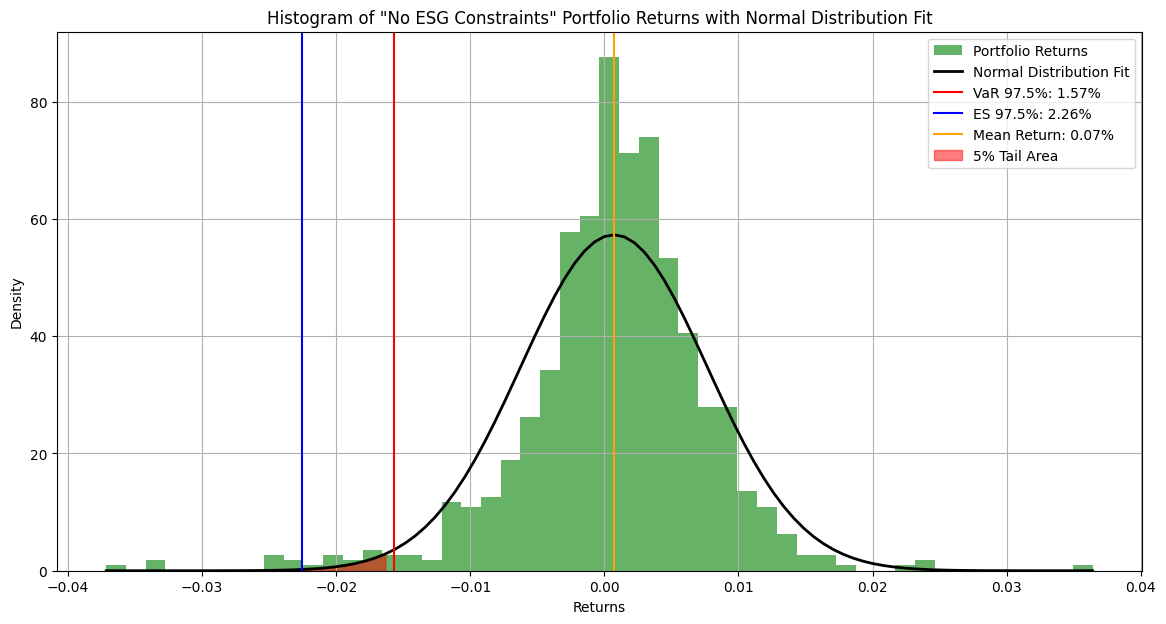

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

#Assuming conv_sh_rets contains the returns for the "No Screen" portfolio

#Calculate VaR and ES for the "No Screen" portfolio
var_conv = calculate_var(conv_sh_rets)
es_conv = calculate_es(conv_sh_rets)

#Fit a normal distribution to the data
mu_conv, std_conv = norm.fit(conv_sh_rets)
x_range_conv = np.linspace(conv_sh_rets.min(), conv_sh_rets.max(), 100)
pdf_values_conv = norm.pdf(x_range_conv, mu_conv, std_conv)

#Calculate the mean return for the "No Screen" portfolio
mean_return_conv = conv_sh_rets.mean()

#Plot the histogram of returns for the "No Screen" portfolio
plt.figure(figsize=(14, 7))
plt.hist(conv_sh_rets, bins=50, density=True, alpha=0.6, color='g', label='Portfolio Returns')
plt.plot(x_range_conv, pdf_values_conv, color='k', linewidth=2, label='Normal Distribution Fit')

#Mark VaR and ES on the plot
plt.axvline(-var_conv, color='r', linestyle='-', label=f'VaR 97.5%: {var_conv*100:.2f}%')
plt.axvline(-es_conv, color='b', linestyle='-', label=f'ES 97.5%: {es_conv*100:.2f}%')
plt.axvline(mean_return_conv, color='orange', linestyle='-', label=f'Mean Return: {mean_return_conv*100:.2f}%')

# Shade the 5% tail area
mask_conv = x_range_conv < -var_conv
plt.fill_between(x_range_conv, pdf_values_conv, where=mask_conv, color='red', alpha=0.5, label='5% Tail Area')

plt.xlabel('Returns')
plt.ylabel('Density')
plt.title('Histogram of "No ESG Constraints" Portfolio Returns with Normal Distribution Fit')
plt.legend()
plt.grid(True)
plt.show()


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


var_conv = calculate_var(esg_sh_rets)
es_conv = calculate_es(esg_sh_rets)


mu_conv, std_conv = norm.fit(esg_sh_rets)
x_range_conv = np.linspace(esg_sh_rets.min(), esg_sh_rets.max(), 100)
pdf_values_conv = norm.pdf(x_range_conv, mu_conv, std_conv)


mean_return_conv = esg_sh_rets.mean()


plt.figure(figsize=(14, 7))
plt.hist(esg_sh_rets, bins=50, density=True, alpha=0.6, color='g', label='Portfolio Returns')
plt.plot(x_range_conv, pdf_values_conv, color='k', linewidth=2, label='Normal Distribution Fit')

plt.axvline(-var_conv, color='r', linestyle='-', label=f'VaR 97.5%: {var_conv*100:.2f}%')
plt.axvline(-es_conv, color='b', linestyle='-', label=f'ES 97.5%: {es_conv*100:.2f}%')
plt.axvline(mean_return_conv, color='orange', linestyle='-', label=f'Mean Return: {mean_return_conv*100:.2f}%')


mask_conv = x_range_conv < -var_conv
plt.fill_between(x_range_conv, pdf_values_conv, where=mask_conv, color='red', alpha=0.5, label='5% Tail Area')

plt.xlabel('Returns')
plt.ylabel('Density')
plt.title('Histogram of "ESG" Portfolio Returns with Normal Distribution Fit')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'calculate_var' is not defined

In [ ]:
import plotly.graph_objects as go

# Initialize a figure
fig = go.Figure()

# Format the VaR and Expected Shortfall values to 5 decimal places
var_text = [f"{x:.7f}" for x in results_df['VaR']]
es_text = [f"{x:.7f}" for x in results_df['ES']]

# Add VaR bar to the figure, including formatted text for data labels inside bars
fig.add_trace(go.Bar(
    y=results_df['Strategy'],  # 'y' represents the strategies
    x=results_df['VaR'],  # VaR values
    name='VaR',
    marker_color='indianred',
    orientation='h',  # Bars are horizontal
    text=var_text,  # Display formatted VaR values inside bars
    textposition='inside'  # Position the text inside the bars
))

# Add ES bar to the figure, including formatted text for data labels inside bars
fig.add_trace(go.Bar(
    y=results_df['Strategy'],  # 'y' represents the strategies
    x=results_df['ES'],  # Expected Shortfall values
    name='Expected Shortfall',
    marker_color='lightblue',
    orientation='h',  # Bars are horizontal
    text=es_text,  # Display formatted Expected Shortfall values inside bars
    textposition='inside'  # Position the text inside the bars
))

# Update the layout for a clearer view
fig.update_layout(
    title='Comparison of Value at Risk (VaR) and Expected Shortfall (ES) by Strategy',
    yaxis_title='Strategy',
    xaxis_title='Value',
    barmode='group',
    width=1000,
    height=500
)

# Display the figure
fig.show()


In [ ]:
import altair as alt
import pandas as pd

# Assuming results_df is your DataFrame and is already defined
# Here's an example of how it might look:
# results_df = pd.DataFrame({
#     'Strategy': ['Strategy A', 'Strategy B', 'Strategy C'],
#     'VaR': [-0.05, -0.06, -0.07],
#     'ES': [-0.07, -0.08, -0.09]
# })

# Prepare data for text labels by formatting the VaR and ES values
results_df['Var_text'] = results_df['VaR'].apply(lambda x: f"{x:.7f}")
results_df['ES_text'] = results_df['ES'].apply(lambda x: f"{x:.7f}")

# Melt the DataFrame to make it long-form for easier plotting with Altair
melted_df = pd.melt(results_df, id_vars=['Strategy', 'Var_text', 'ES_text'], value_vars=['VaR', 'ES'], var_name='Type', value_name='Value')

# Create the base bar chart
bar_chart = alt.Chart(melted_df).mark_bar().encode(
    x='Value:Q',
    y=alt.Y('Strategy:N', sort=None),  # sort=None to keep the original order
    color='Type:N',
    tooltip=['Strategy', 'Value', 'Var_text', 'ES_text']
).properties(
    width=1200,
    height=300,
    title='Comparison of Value at Risk (VaR) and Expected Shortfall (ES) by Strategy'
)

# Add text labels for the VaR values
var_text = bar_chart.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudge the text to the right of the bar's end for readability
).encode(
    text='Var_text:N'
).transform_filter(
    alt.datum.Type == 'VaR'  # Only display this text for VaR bars
)

# Add text labels for the ES values
es_text = bar_chart.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudge the text to the right of the bar's end for readability
).encode(
    text='ES_text:N'
).transform_filter(
    alt.datum.Type == 'ES'  # Only display this text for ES bars
)

# Combine the charts
alt.layer(bar_chart, var_text, es_text).configure_view(
    stroke=None  # Remove the border around the chart
)


alt.LayerChart(...)

In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np
import plotly.graph_objects as go

#NSGA-II tickers and weights
nsga_ii_tickers = ['CTAS', 'SRE', 'BALL', 'LRCX', 'PG', 'CMS', 'XEL', 'HUM', 'MCO', 'OKE']
nsga_ii_weights = np.array([0.17454666455254889, 0.17301910169579504, 0.13773942486190574, 0.1040582588214583,
                            0.09442172978590976, 0.0832708489778586, 0.07437426808933643, 0.055972984478130414,
                            0.055566838166417554, 0.047029880570639185])

#period
start_date = '2017-01-01'
end_date = '2019-12-31'

#download stock data
nsga_ii_data = yf.download(nsga_ii_tickers, start=start_date, end=end_date)['Adj Close']
spy_data = yf.download('SPY', start=start_date, end=end_date)['Adj Close']

#daily returns
nsga_ii_daily_returns = nsga_ii_data.pct_change().fillna(0)
spy_daily_returns = spy_data.pct_change().fillna(0)

#portfolio returns
nsga_ii_portfolio_returns = (nsga_ii_daily_returns * nsga_ii_weights).sum(axis=1)
spy_portfolio_returns = spy_daily_returns

#cumulative returns
nsga_ii_cumulative_returns = (nsga_ii_portfolio_returns + 1).cumprod()
spy_cumulative_returns = (spy_portfolio_returns + 1).cumprod()

#plotting
fig = go.Figure()

# NSGA-II Portfolio with specific line width
fig.add_trace(go.Scatter(x=nsga_ii_cumulative_returns.index, y=nsga_ii_cumulative_returns,
                         mode='lines', name='NSGA-II Optimized ESG Portfolio',
                         line=dict(color='orange', width=2)))

# Define a Blue Palette for other lines
blue_palette = ['#1f77b4', '#17becf', '#aec7e8', '#7f7f7f', '#7777e8']  # Example palette

# SPY Benchmark with default line width
fig.add_trace(go.Scatter(x=spy_cumulative_returns.index, y=spy_cumulative_returns,
                         mode='lines', name='SPY Benchmark',
                         line=dict(color=blue_palette[0], width=1.4)))


for i, col in enumerate(all_sh_port.columns):
    fig.add_trace(go.Scatter(x=all_sh_port.index, y=all_sh_port[col],
                             mode='lines', name=col,
                             line=dict(color=blue_palette[i % len(blue_palette)], width=1.4)))

# Update layout
fig.update_layout(title='Portfolio Performance Comparison 2017-2019',
                  xaxis_title='Date', yaxis_title='Cumulative Returns',
                  width=1500, template="ggplot2", height=900)

# Display the figure
fig.show()


[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np
import plotly.graph_objects as go

#NSGA-II tickers and weights
nsga_ii_tickers = ['CTAS', 'SRE', 'BALL', 'LRCX', 'PG', 'CMS', 'XEL', 'HUM', 'MCO', 'OKE']
nsga_ii_weights = np.array([0.17454666455254889, 0.17301910169579504, 0.13773942486190574, 0.1040582588214583,
                            0.09442172978590976, 0.0832708489778586, 0.07437426808933643, 0.055972984478130414,
                            0.055566838166417554, 0.047029880570639185])

#period
start_date = '2017-01-01'
end_date = '2019-12-31'

#download stock data
nsga_ii_data = yf.download(nsga_ii_tickers, start=start_date, end=end_date)['Adj Close']
spy_data = yf.download('SPY', start=start_date, end=end_date)['Adj Close']

#daily returns
nsga_ii_daily_returns = nsga_ii_data.pct_change().fillna(0)
spy_daily_returns = spy_data.pct_change().fillna(0)

#portfolio returns
nsga_ii_portfolio_returns = (nsga_ii_daily_returns * nsga_ii_weights).sum(axis=1)
spy_portfolio_returns = spy_daily_returns

#cumulative returns
nsga_ii_cumulative_returns = (nsga_ii_portfolio_returns + 1).cumprod()
spy_cumulative_returns = (spy_portfolio_returns + 1).cumprod()

#plotting
fig = go.Figure()

# NSGA-II Portfolio with specific line width
fig.add_trace(go.Scatter(x=nsga_ii_cumulative_returns.index, y=nsga_ii_cumulative_returns,
                         mode='lines', name='NSGA-II Optimized ESG Portfolio',
                         line=dict(color='orange', width=2)))

# Define a Blue Palette for other lines
blue_palette = ['#1f77b4', '#17becf', '#aec7e8', '#7f7f7f', '#7777e8']  # Example palette

# SPY Benchmark with default line width
fig.add_trace(go.Scatter(x=spy_cumulative_returns.index, y=spy_cumulative_returns,
                         mode='lines', name='SPY Benchmark',
                         line=dict(color='green', width=1.4)))

for i, col in enumerate(all_sh_port.columns):
    fig.add_trace(go.Scatter(x=all_sh_port.index, y=all_sh_port[col],
                             mode='lines', name=col,
                             line=dict(color=blue_palette[i % len(blue_palette)], width=1.4)))

# Update layout
fig.update_layout(title='Portfolio Performance Comparison 2017-2019',
                  xaxis_title='Date', yaxis_title='Cumulative Returns',
                  width=1500, template="ggplot2", height=900)

# Display the figure
fig.show()


[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np
import plotly.graph_objects as go

# NSGA-II tickers and weights
nsga_ii_tickers = ['CTAS', 'SRE', 'BALL', 'LRCX', 'PG', 'CMS', 'XEL', 'HUM', 'MCO', 'OKE']
nsga_ii_weights = np.array([0.17454666455254889, 0.17301910169579504, 0.13773942486190574, 0.1040582588214583,
                            0.09442172978590976, 0.0832708489778586, 0.07437426808933643, 0.055972984478130414,
                            0.055566838166417554, 0.047029880570639185])

# Period
start_date = '2017-01-01'
end_date = '2019-12-31'

# Download stock data
nsga_ii_data = yf.download(nsga_ii_tickers, start=start_date, end=end_date)['Adj Close']
spy_data = yf.download('SPY', start=start_date, end=end_date)['Adj Close']

# Daily returns
nsga_ii_daily_returns = nsga_ii_data.pct_change().fillna(0)
spy_daily_returns = spy_data.pct_change().fillna(0)

# Portfolio returns
nsga_ii_portfolio_returns = (nsga_ii_daily_returns * nsga_ii_weights).sum(axis=1)
spy_portfolio_returns = spy_daily_returns

# Cumulative returns
nsga_ii_cumulative_returns = (nsga_ii_portfolio_returns + 1).cumprod()
spy_cumulative_returns = (spy_portfolio_returns + 1).cumprod()

# Plotting
fig = go.Figure()

# NSGA-II Portfolio with specific line width
fig.add_trace(go.Scatter(x=nsga_ii_cumulative_returns.index, y=nsga_ii_cumulative_returns,
                         mode='lines', name='NSGA-II Optimized ESG Portfolio',
                         line=dict(color='orange', width=2)))

# Define a Blue Palette for other lines
blue_palette = ['#1f77b4', '#17becf', '#aec7e8', '#7f7f7f', '#7777e8']  # Example palette

# SPY Benchmark with default line width
fig.add_trace(go.Scatter(x=spy_cumulative_returns.index, y=spy_cumulative_returns,
                         mode='lines', name='SPY Benchmark',
                         line=dict(color='green', width=1.4)))

for i, col in enumerate(all_sh_port.columns):
    fig.add_trace(go.Scatter(x=all_sh_port.index, y=all_sh_port[col],
                             mode='lines', name=col,
                             line=dict(color=blue_palette[i % len(blue_palette)], width=1.4)))

# Update layout
fig.update_layout(title='Portfolio Performance Comparison 2017-2019',
                  xaxis_title='Date', yaxis_title='Cumulative Returns',
                  width=1500, template="ggplot2", height=900)

# Display the figure
fig.show()

# Calculate the cumulative return for each portfolio over the in-sample period
in_sample_performance = (all_sh_port.iloc[-1] - all_sh_port.iloc[0]) / all_sh_port.iloc[0]

# Calculate the cumulative return for NSGA-II and SPY
nsga_ii_performance = (nsga_ii_cumulative_returns.iloc[-1] - nsga_ii_cumulative_returns.iloc[0]) / nsga_ii_cumulative_returns.iloc[0]
spy_performance = (spy_cumulative_returns.iloc[-1] - spy_cumulative_returns.iloc[0]) / spy_cumulative_returns.iloc[0]

# Add NSGA-II and SPY performance to the DataFrame
in_sample_performance['NSGA-II Optimized ESG Portfolio'] = nsga_ii_performance
in_sample_performance['SPY Benchmark'] = spy_performance

# Display the performance of each portfolio
print("In-Sample Performance:")
print(in_sample_performance)

# Create a DataFrame for easier reading and potential plotting
in_sample_performance_df = in_sample_performance.reset_index()
in_sample_performance_df.columns = ['Portfolio', 'Cumulative Return']



# Plot the performance of each portfolio as a bar chart
fig = px.bar(in_sample_performance_df, x='Portfolio', y='Cumulative Return', title='In-Sample Performance of Portfolios (2017-2019)', labels={'Cumulative Return':'Cumulative Return (%)'})
fig.show()


[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  1 of 1 completed


In-Sample Performance:
No ESG Constraints                 0.681351
E                                  0.598449
S                                  0.540642
G                                  0.499778
ESG                                0.555020
NSGA-II Optimized ESG Portfolio    1.023846
SPY Benchmark                      0.508859
dtype: float64


In [ ]:
# Calculate the cumulative return for each portfolio over the in-sample period
in_sample_performance = (all_sh_port.iloc[-1] - all_sh_port.iloc[0]) / all_sh_port.iloc[0]

# Calculate the cumulative return for NSGA-II and SPY
nsga_ii_performance = (nsga_ii_cumulative_returns.iloc[-1] - nsga_ii_cumulative_returns.iloc[0]) / nsga_ii_cumulative_returns.iloc[0]
spy_performance = (spy_cumulative_returns.iloc[-1] - spy_cumulative_returns.iloc[0]) / spy_cumulative_returns.iloc[0]

# Add NSGA-II and SPY performance to the Series
in_sample_performance['NSGA-II Optimized ESG Portfolio'] = nsga_ii_performance
in_sample_performance['SPY Benchmark'] = spy_performance

# Display the performance of each portfolio
print("In-Sample Performance:")
print(in_sample_performance)


In-Sample Performance:
No ESG Constraints                 0.681351
E                                  0.598449
S                                  0.540642
G                                  0.499778
ESG                                0.555020
NSGA-II Optimized ESG Portfolio    1.023846
SPY Benchmark                      0.508859
dtype: float64


In [ ]:
# Calculate the cumulative return for each portfolio over the in-sample period
in_sample_performance = (all_sh_port.iloc[-1] - all_sh_port.iloc[0]) / all_sh_port.iloc[0]

# Calculate the cumulative return for NSGA-II and SPY
nsga_ii_performance = (nsga_ii_cumulative_returns.iloc[-1] - nsga_ii_cumulative_returns.iloc[0]) / nsga_ii_cumulative_returns.iloc[0]
spy_performance = (spy_cumulative_returns.iloc[-1] - spy_cumulative_returns.iloc[0]) / spy_cumulative_returns.iloc[0]

# Add NSGA-II and SPY performance to the Series
in_sample_performance['NSGA-II Optimized ESG Portfolio'] = nsga_ii_performance
in_sample_performance['SPY Benchmark'] = spy_performance

# Convert to percentage format
in_sample_performance = (in_sample_performance * 100).round(2)

# Display the performance of each portfolio
print("In-Sample Performance (%):")
print(in_sample_performance)


In-Sample Performance (%):
No ESG Constraints                  68.14
E                                   59.84
S                                   54.06
G                                   49.98
ESG                                 55.50
NSGA-II Optimized ESG Portfolio    102.38
SPY Benchmark                       50.89
dtype: float64


In [ ]:
# Function to calculate volatility of portfolios
def compute_volatility(portfolios):
    volatilities = portfolios.pct_change().std()
    return volatilities

# Calculate volatilities for in-sample portfolios
in_sample_volatilities = compute_volatility(all_sh_port)

# Calculate volatilities for NSGA-II and SPY
nsga_ii_volatility = compute_volatility(nsga_ii_cumulative_returns.to_frame())
spy_volatility = compute_volatility(spy_cumulative_returns.to_frame())

# Add NSGA-II and SPY volatilities to the Series
in_sample_volatilities['NSGA-II Optimized ESG Portfolio'] = nsga_ii_volatility[0]
in_sample_volatilities['SPY Benchmark'] = spy_volatility[0]


# Calculate volatilities for out-of-sample portfolios
out_of_sample_volatilities = compute_volatility(all_sh_port_oos)

# Since we don't have out-of-sample data for NSGA-II and SPY in this code, we can either exclude them or assume the same period as for in-sample.
nsga_ii_volatility_oos = compute_volatility(nsga_ii_cumulative_returns.to_frame())
spy_volatility_oos = compute_volatility(spy_cumulative_returns.to_frame())

# Add NSGA-II and SPY volatilities to the Series
out_of_sample_volatilities['NSGA-II Optimized ESG Portfolio'] = nsga_ii_volatility_oos[0]
out_of_sample_volatilities['SPY Benchmark'] = spy_volatility_oos[0]

print("\nOut-of-Sample Volatilities (%):")
print((out_of_sample_volatilities * 100).round(4))



Out-of-Sample Volatilities (%):
No ESG Constraints                 0.6971
E                                  0.7422
S                                  0.7328
G                                  0.6958
ESG                                0.7254
NSGA-II Optimized ESG Portfolio    0.7550
SPY Benchmark                      0.8082
dtype: float64


In [ ]:
import pandas as pd
import numpy as np

# Function to calculate VaR
def calculate_var(returns, confidence_level=0.975):
    return -np.percentile(returns, 100 * (1 - confidence_level))

# Function to calculate ES
def calculate_es(returns, confidence_level=0.975):
    var = calculate_var(returns, confidence_level)
    return -returns[returns <= -var].mean()

# Assuming conv_sh_rets, e_sh_rets, g_sh_rets, s_sh_rets, esg_sh_rets, nsga_ii_portfolio_returns, spy_portfolio_returns are loaded

# Dictionary of strategy names and their corresponding returns
strategies_returns = {
    'No ESG Constraints': conv_sh_rets,
    'E': e_sh_rets,
    'S': s_sh_rets,
    'G': g_sh_rets,
    'ESG': esg_sh_rets,
    'NSGA-II Optimized ESG Portfolio': nsga_ii_portfolio_returns,
    'SPY Benchmark': spy_portfolio_returns
}

# Initialize an empty list to store DataFrame rows
rows_list = []

# Loop through each strategy and calculate VaR and ES
for strategy_name, returns in strategies_returns.items():
    var = calculate_var(returns)
    es = calculate_es(returns)
    # Append the results as a dictionary to the rows list
    rows_list.append({'Strategy': strategy_name, 'VaR': var, 'ES': es})

# Convert the list of dictionaries to a DataFrame
results_df = pd.DataFrame(rows_list)

# Display the results
print(results_df)

import plotly.graph_objects as go

# Initialize a figure
fig = go.Figure()

# Format the VaR and Expected Shortfall values to 4 decimal places
var_text = [f"{x:.7f}" for x in results_df['VaR']]
es_text = [f"{x:.7f}" for x in results_df['ES']]

# Add VaR bar to the figure, including formatted text for data labels inside bars
fig.add_trace(go.Bar(
    y=results_df['Strategy'],  # 'y' represents the strategies
    x=results_df['VaR'],  # VaR values
    name='VaR',
    marker_color='indianred',
    orientation='h',  # Bars are horizontal
    text=var_text,  # Display formatted VaR values inside bars
    textposition='inside'  # Position the text inside the bars
))

# Add ES bar to the figure, including formatted text for data labels inside bars
fig.add_trace(go.Bar(
    y=results_df['Strategy'],  # 'y' represents the strategies
    x=results_df['ES'],  # Expected Shortfall values
    name='Expected Shortfall',
    marker_color='lightblue',
    orientation='h',  # Bars are horizontal
    text=es_text,  # Display formatted Expected Shortfall values inside bars
    textposition='inside'  # Position the text inside the bars
))

# Update the layout for a clearer view
fig.update_layout(
    title='Comparison of Value at Risk (VaR) and Expected Shortfall (ES) by Strategy',
    yaxis_title='Strategy',
    xaxis_title='Value',
    barmode='group',
    width=1100,
    height=500
)

# Display the figure
fig.show()


                          Strategy       VaR        ES
0               No ESG Constraints  0.015719  0.022554
1                                E  0.017597  0.024086
2                                S  0.017484  0.023910
3                                G  0.016148  0.022570
4                              ESG  0.016932  0.023490
5  NSGA-II Optimized ESG Portfolio  0.015740  0.022017
6                    SPY Benchmark  0.019793  0.026955


In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import plotly.graph_objects as go

# Function to calculate cumulative return
def calculate_cumulative_return(returns):
    return (returns + 1).prod() - 1

# Function to calculate annual return
def calculate_annual_return(returns):
    cumulative_return = calculate_cumulative_return(returns)
    n_years = len(returns) / 252
    return (1 + cumulative_return) ** (1 / n_years) - 1

# Function to calculate standard deviation (annualized)
def calculate_annual_std(returns):
    return returns.std() * np.sqrt(252)

# Function to calculate beta
def calculate_beta(returns, benchmark_returns):
    aligned_returns = returns.align(benchmark_returns, join='inner')[0]
    aligned_benchmark = benchmark_returns.align(returns, join='inner')[0]
    covariance_matrix = np.cov(aligned_returns, aligned_benchmark)
    beta = covariance_matrix[0, 1] / covariance_matrix[1, 1]
    return beta

# Function to calculate Sharpe Ratio
def calculate_sharpe_ratio(returns, risk_free_rate=0.02):
    return (returns.mean() - risk_free_rate / 252) / returns.std() * np.sqrt(252)

# Function to calculate Treynor Ratio
def calculate_treynor_ratio(returns, benchmark_returns, risk_free_rate=0.02):
    beta = calculate_beta(returns, benchmark_returns)
    return (returns.mean() - risk_free_rate / 252) / beta

# Function to calculate maximum drawdown
def calculate_max_drawdown(cumulative_returns):
    roll_max = cumulative_returns.cummax()
    daily_drawdown = cumulative_returns / roll_max - 1.0
    max_drawdown = daily_drawdown.cummin()
    return max_drawdown.min()

# Function to calculate skewness
def calculate_skewness(returns):
    return stats.skew(returns)

# Function to calculate kurtosis
def calculate_kurtosis(returns):
    return stats.kurtosis(returns)

# Dictionary to store performance measures
performance_measures = {
    'Portfolio': [],
    'Cumulative Return': [],
    'Annual Return': [],
    'Standard Deviation': [],
    'Beta': [],
    'Sharpe Ratio': [],
    'Treynor Ratio': [],
    'Skewness': [],
    'Kurtosis': [],
    'Maximum Drawdown': []
}

# Calculate performance measures for each portfolio
benchmark_returns = spy_daily_returns

for strategy, cumulative_returns in all_sh_port.items():
    daily_returns = cumulative_returns.pct_change().dropna()
    performance_measures['Portfolio'].append(strategy)
    performance_measures['Cumulative Return'].append(calculate_cumulative_return(daily_returns))
    performance_measures['Annual Return'].append(calculate_annual_return(daily_returns))
    performance_measures['Standard Deviation'].append(calculate_annual_std(daily_returns))
    performance_measures['Beta'].append(calculate_beta(daily_returns, benchmark_returns))
    performance_measures['Sharpe Ratio'].append(calculate_sharpe_ratio(daily_returns))
    performance_measures['Treynor Ratio'].append(calculate_treynor_ratio(daily_returns, benchmark_returns))
    performance_measures['Skewness'].append(calculate_skewness(daily_returns))
    performance_measures['Kurtosis'].append(calculate_kurtosis(daily_returns))
    performance_measures['Maximum Drawdown'].append(calculate_max_drawdown(cumulative_returns))

# Calculate performance measures for NSGA-II and SPY
nsga_ii_daily_returns = nsga_ii_cumulative_returns.pct_change().dropna()
spy_daily_returns = spy_cumulative_returns.pct_change().dropna()

for strategy, daily_returns in {'NSGA-II Optimized ESG Portfolio': nsga_ii_daily_returns, 'SPY Benchmark': spy_daily_returns}.items():
    performance_measures['Portfolio'].append(strategy)
    performance_measures['Cumulative Return'].append(calculate_cumulative_return(daily_returns))
    performance_measures['Annual Return'].append(calculate_annual_return(daily_returns))
    performance_measures['Standard Deviation'].append(calculate_annual_std(daily_returns))
    performance_measures['Beta'].append(calculate_beta(daily_returns, benchmark_returns))
    performance_measures['Sharpe Ratio'].append(calculate_sharpe_ratio(daily_returns))
    performance_measures['Treynor Ratio'].append(calculate_treynor_ratio(daily_returns, benchmark_returns))
    performance_measures['Skewness'].append(calculate_skewness(daily_returns))
    performance_measures['Kurtosis'].append(calculate_kurtosis(daily_returns))
    performance_measures['Maximum Drawdown'].append(calculate_max_drawdown(cumulative_returns))

# Convert dictionary to DataFrame
performance_measures_df = pd.DataFrame(performance_measures)

# Format the DataFrame for better readability
performance_measures_df['Cumulative Return'] = (performance_measures_df['Cumulative Return'] * 100).round(2).astype(str) + '%'
performance_measures_df['Annual Return'] = (performance_measures_df['Annual Return'] * 100).round(2).astype(str) + '%'
performance_measures_df['Standard Deviation'] = (performance_measures_df['Standard Deviation'] * 100).round(2).astype(str) + '%'
performance_measures_df['Beta'] = performance_measures_df['Beta'].round(2)
performance_measures_df['Sharpe Ratio'] = performance_measures_df['Sharpe Ratio'].round(2)
performance_measures_df['Treynor Ratio'] = performance_measures_df['Treynor Ratio'].round(2)
performance_measures_df['Skewness'] = performance_measures_df['Skewness'].round(2)
performance_measures_df['Kurtosis'] = performance_measures_df['Kurtosis'].round(2)
performance_measures_df['Maximum Drawdown'] = (performance_measures_df['Maximum Drawdown'] * 100).round(2).astype(str) + '%'

print(performance_measures_df)


                         Portfolio Cumulative Return Annual Return  \
0               No ESG Constraints            68.14%        19.02%   
1                                E            59.84%        17.02%   
2                                S            54.06%        15.58%   
3                                G            49.98%        14.55%   
4                              ESG             55.5%        15.94%   
5  NSGA-II Optimized ESG Portfolio           102.38%        26.65%   
6                    SPY Benchmark            50.89%        14.78%   

  Standard Deviation  Beta  Sharpe Ratio  Treynor Ratio  Skewness  Kurtosis  \
0             11.07%  0.76          1.45            0.0     -0.73      4.23   
1             11.78%  0.84          1.22            0.0     -0.71      4.09   
2             11.63%  0.83          1.13            0.0     -0.71      4.21   
3             11.05%  0.76          1.10            0.0     -0.71      4.10   
4             11.52%  0.81          1.17    

In [ ]:
import statsmodels.api as sm

# Function to calculate Alpha and Beta using statsmodels
def calculate_alpha_beta(returns, benchmark_returns, risk_free_rate=0.02):
    excess_returns = returns - risk_free_rate / 252
    excess_benchmark = benchmark_returns - risk_free_rate / 252
    excess_benchmark = sm.add_constant(excess_benchmark)  # Adds a constant term to the predictor
    model = sm.OLS(excess_returns, excess_benchmark).fit()
    alpha = model.params[0] * 252  # annualize alpha
    beta = model.params[1]
    return alpha, beta

# Function to calculate R-squared using statsmodels
def calculate_r_squared(returns, benchmark_returns, risk_free_rate=0.02):
    excess_returns = returns - risk_free_rate / 252
    excess_benchmark = benchmark_returns - risk_free_rate / 252
    excess_benchmark = sm.add_constant(excess_benchmark)  # Adds a constant term to the predictor
    model = sm.OLS(excess_returns, excess_benchmark).fit()
    return model.rsquared


In [ ]:
# Dictionary to store performance measures (including CAPM model statistics)
performance_measures = {
    'Portfolio': [],
    'Cumulative Return': [],
    'Annual Return': [],
    'Standard Deviation': [],
    'Beta': [],
    'Sharpe Ratio': [],
    'Treynor Ratio': [],
    'Alpha': [],
    'R-squared': [],
    'Skewness': [],
    'Kurtosis': [],
    'Maximum Drawdown': []
}

# Calculate performance measures for each portfolio
benchmark_returns = spy_daily_returns

for strategy, cumulative_returns in all_sh_port.items():
    daily_returns = cumulative_returns.pct_change().dropna()
    alpha, beta = calculate_alpha_beta(daily_returns, benchmark_returns)
    performance_measures['Portfolio'].append(strategy)
    performance_measures['Cumulative Return'].append(calculate_cumulative_return(daily_returns))
    performance_measures['Annual Return'].append(calculate_annual_return(daily_returns))
    performance_measures['Standard Deviation'].append(calculate_annual_std(daily_returns))
    performance_measures['Beta'].append(beta)
    performance_measures['Sharpe Ratio'].append(calculate_sharpe_ratio(daily_returns))
    performance_measures['Treynor Ratio'].append(calculate_treynor_ratio(daily_returns, benchmark_returns))
    performance_measures['Alpha'].append(alpha)
    performance_measures['R-squared'].append(calculate_r_squared(daily_returns, benchmark_returns))
    performance_measures['Skewness'].append(calculate_skewness(daily_returns))
    performance_measures['Kurtosis'].append(calculate_kurtosis(daily_returns))
    performance_measures['Maximum Drawdown'].append(calculate_max_drawdown(cumulative_returns))

# Calculate performance measures for NSGA-II and SPY
nsga_ii_daily_returns = nsga_ii_cumulative_returns.pct_change().dropna()
spy_daily_returns = spy_cumulative_returns.pct_change().dropna()

for strategy, daily_returns in {'NSGA-II Optimized ESG Portfolio': nsga_ii_daily_returns, 'SPY Benchmark': spy_daily_returns}.items():
    alpha, beta = calculate_alpha_beta(daily_returns, benchmark_returns)
    performance_measures['Portfolio'].append(strategy)
    performance_measures['Cumulative Return'].append(calculate_cumulative_return(daily_returns))
    performance_measures['Annual Return'].append(calculate_annual_return(daily_returns))
    performance_measures['Standard Deviation'].append(calculate_annual_std(daily_returns))
    performance_measures['Beta'].append(beta)
    performance_measures['Sharpe Ratio'].append(calculate_sharpe_ratio(daily_returns))
    performance_measures['Treynor Ratio'].append(calculate_treynor_ratio(daily_returns, benchmark_returns))
    performance_measures['Alpha'].append(alpha)
    performance_measures['R-squared'].append(calculate_r_squared(daily_returns, benchmark_returns))
    performance_measures['Skewness'].append(calculate_skewness(daily_returns))
    performance_measures['Kurtosis'].append(calculate_kurtosis(daily_returns))
    performance_measures['Maximum Drawdown'].append(calculate_max_drawdown(cumulative_returns))

# Convert dictionary to DataFrame
performance_measures_df = pd.DataFrame(performance_measures)

# Format the DataFrame for better readability
performance_measures_df['Cumulative Return'] = (performance_measures_df['Cumulative Return'] * 100).round(2).astype(str) + '%'
performance_measures_df['Annual Return'] = (performance_measures_df['Annual Return'] * 100).round(2).astype(str) + '%'
performance_measures_df['Standard Deviation'] = (performance_measures_df['Standard Deviation'] * 100).round(2).astype(str) + '%'
performance_measures_df['Beta'] = performance_measures_df['Beta'].round(2)
performance_measures_df['Sharpe Ratio'] = performance_measures_df['Sharpe Ratio'].round(2)
performance_measures_df['Treynor Ratio'] = performance_measures_df['Treynor Ratio'].round(2)
performance_measures_df['Alpha'] = performance_measures_df['Alpha'].round(2)
performance_measures_df['R-squared'] = performance_measures_df['R-squared'].round(2)
performance_measures_df['Skewness'] = performance_measures_df['Skewness'].round(2)
performance_measures_df['Kurtosis'] = performance_measures_df['Kurtosis'].round(2)
performance_measures_df['Maximum Drawdown'] = (performance_measures_df['Maximum Drawdown'] * 100).round(2).astype(str) + '%'

print(performance_measures_df)


                         Portfolio Cumulative Return Annual Return  \
0               No ESG Constraints            68.14%        19.02%   
1                                E            59.84%        17.02%   
2                                S            54.06%        15.58%   
3                                G            49.98%        14.55%   
4                              ESG             55.5%        15.94%   
5  NSGA-II Optimized ESG Portfolio           102.38%        26.65%   
6                    SPY Benchmark            50.89%        14.78%   

  Standard Deviation  Beta  Sharpe Ratio  Treynor Ratio  Alpha  R-squared  \
0             11.07%  0.76          1.45            0.0   0.06       0.78   
1             11.78%  0.84          1.22            0.0   0.04       0.83   
2             11.63%  0.83          1.13            0.0   0.03       0.84   
3             11.05%  0.76          1.10            0.0   0.03       0.78   
4             11.52%  0.81          1.17            0.

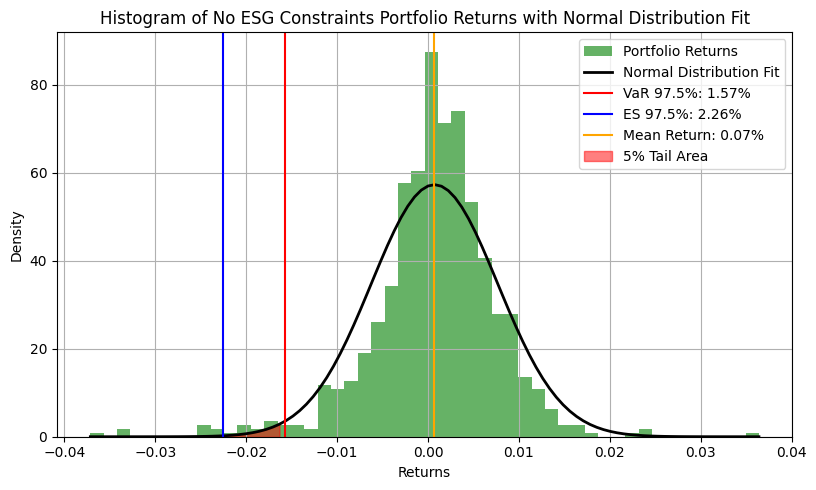

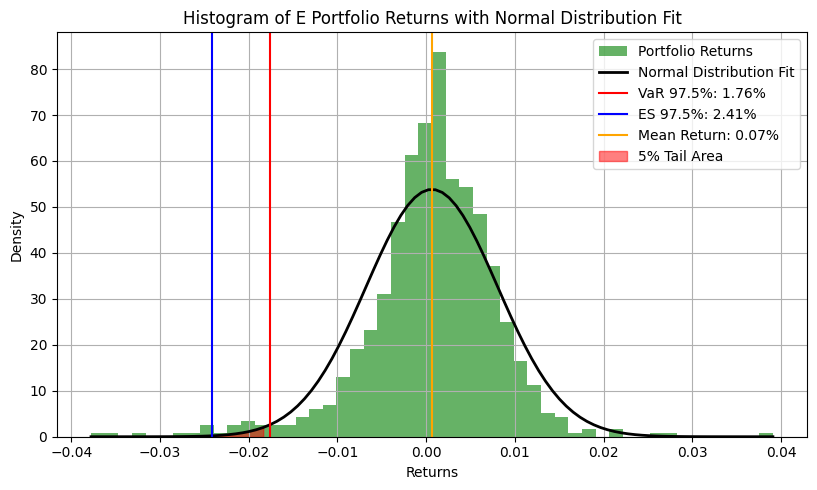

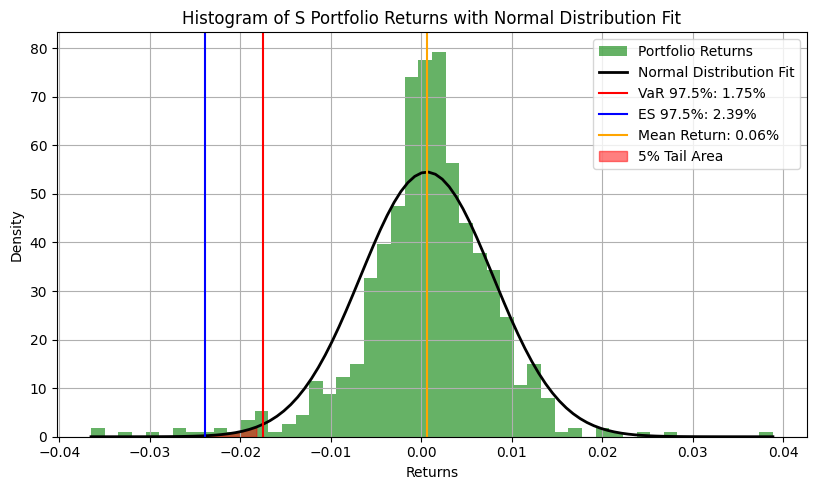

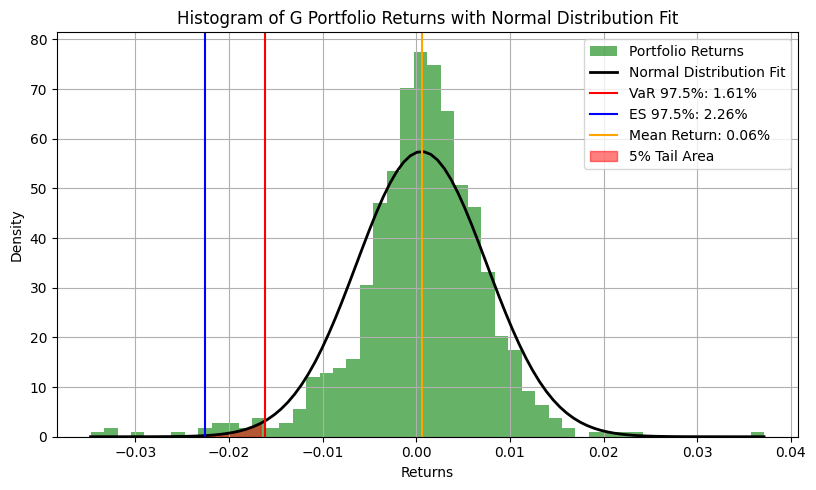

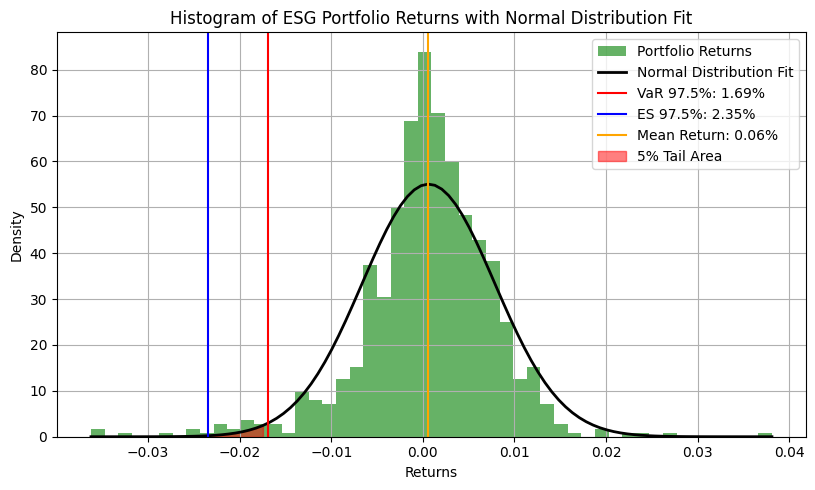

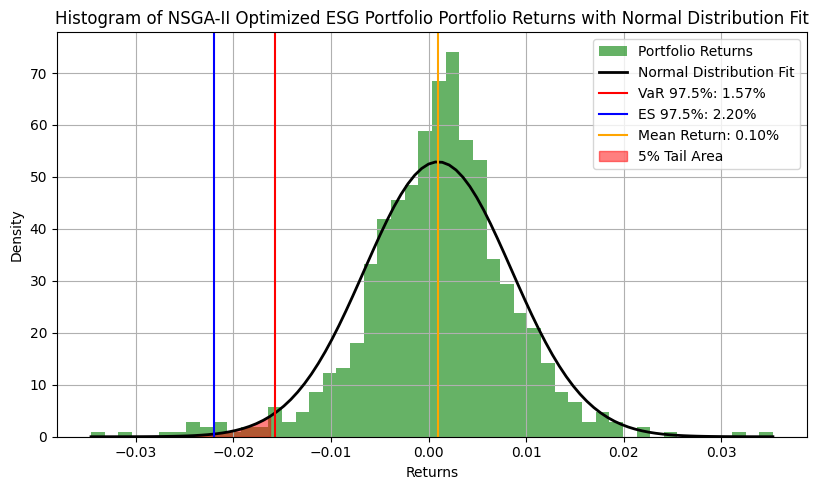

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Function to calculate VaR
def calculate_var(returns, confidence_level=0.975):
    return -np.percentile(returns, 100 * (1 - confidence_level))

# Function to calculate ES
def calculate_es(returns, confidence_level=0.975):
    var = calculate_var(returns, confidence_level)
    return -returns[returns <= -var].mean()

# Assuming conv_sh_rets, e_sh_rets, g_sh_rets, s_sh_rets, esg_sh_rets, nsga_ii_portfolio_returns, spy_portfolio_returns are loaded

# Dictionary of strategy names and their corresponding returns
strategies_returns = {
    'No ESG Constraints': conv_sh_rets,
    'E': e_sh_rets,
    'S': s_sh_rets,
    'G': g_sh_rets,
    'ESG': esg_sh_rets,
    'NSGA-II Optimized ESG Portfolio': nsga_ii_portfolio_returns,
}

# Loop through each strategy and plot the histogram with VaR and ES
for strategy_name, returns in strategies_returns.items():
    # Calculate VaR and ES
    var = calculate_var(returns)
    es = calculate_es(returns)

    # Fit a normal distribution to the data
    mu, std = norm.fit(returns)
    x_range = np.linspace(returns.min(), returns.max(), 100)
    pdf_values = norm.pdf(x_range, mu, std)

    # Calculate the mean return for the portfolio
    mean_return = returns.mean()

    # Plot the histogram of returns for the portfolio
    plt.figure(figsize=(8.27, 5))  # Adjusted figure size for A4 page fitting
    plt.hist(returns, bins=50, density=True, alpha=0.6, color='g', label='Portfolio Returns')
    plt.plot(x_range, pdf_values, color='k', linewidth=2, label='Normal Distribution Fit')

    # Mark VaR and ES on the plot
    plt.axvline(-var, color='r', linestyle='-', label=f'VaR 97.5%: {var*100:.2f}%')
    plt.axvline(-es, color='b', linestyle='-', label=f'ES 97.5%: {es*100:.2f}%')
    plt.axvline(mean_return, color='orange', linestyle='-', label=f'Mean Return: {mean_return*100:.2f}%')

    # Shade the 5% tail area
    mask = x_range < -var
    plt.fill_between(x_range, pdf_values, where=mask, color='red', alpha=0.5, label='5% Tail Area')

    plt.xlabel('Returns')
    plt.ylabel('Density')
    plt.title(f'Histogram of {strategy_name} Portfolio Returns with Normal Distribution Fit')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()  # Ensures everything fits within the plot area
    plt.show()


In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np
import plotly.graph_objects as go
import plotly.express as px

# NSGA-II tickers and weights
nsga_ii_tickers = ['CTAS', 'SRE', 'BALL', 'LRCX', 'PG', 'CMS', 'XEL', 'HUM', 'MCO', 'OKE']
nsga_ii_weights = np.array([0.17454666455254889, 0.17301910169579504, 0.13773942486190574, 0.1040582588214583,
                            0.09442172978590976, 0.0832708489778586, 0.07437426808933643, 0.055972984478130414,
                            0.055566838166417554, 0.047029880570639185])

# Period
start_date = '2017-01-01'
end_date = '2019-12-31'

# Download stock data
nsga_ii_data = yf.download(nsga_ii_tickers, start=start_date, end=end_date)['Adj Close']
spy_data = yf.download('SPY', start=start_date, end=end_date)['Adj Close']

# Daily returns
nsga_ii_daily_returns = nsga_ii_data.pct_change().fillna(0)
spy_daily_returns = spy_data.pct_change().fillna(0)

# Portfolio returns
nsga_ii_portfolio_returns = (nsga_ii_daily_returns * nsga_ii_weights).sum(axis=1)
spy_portfolio_returns = spy_daily_returns

# Cumulative returns
nsga_ii_cumulative_returns = (nsga_ii_portfolio_returns + 1).cumprod()
spy_cumulative_returns = (spy_portfolio_returns + 1).cumprod()

# Plotting
fig = go.Figure()

# NSGA-II Portfolio with specific line width
fig.add_trace(go.Scatter(x=nsga_ii_cumulative_returns.index, y=nsga_ii_cumulative_returns,
                         mode='lines', name='NSGA-II Optimized ESG Portfolio',
                         line=dict(color='orange', width=2)))

# Define a Blue Palette for other lines
blue_palette = ['#1f77b4', '#17becf', '#aec7e8', '#7f7f7f', '#7777e8']  # Example palette

# SPY Benchmark with default line width
fig.add_trace(go.Scatter(x=spy_cumulative_returns.index, y=spy_cumulative_returns,
                         mode='lines', name='SPY Benchmark',
                         line=dict(color='green', width=1.4)))

# Assuming all_sh_port DataFrame is defined and contains the additional portfolios
for i, col in enumerate(all_sh_port.columns):
    fig.add_trace(go.Scatter(x=all_sh_port.index, y=all_sh_port[col],
                             mode='lines', name=col,
                             line=dict(color=blue_palette[i % len(blue_palette)], width=1.4)))

# Update layout
fig.update_layout(title='Portfolio Performance Comparison 2017-2019',
                  xaxis_title='Date', yaxis_title='Cumulative Returns',
                  width=1500, template="ggplot2", height=900)

# Display the figure
fig.show()

# Save the figure in high definition
fig.write_image("portfolio_performance_comparison.png", scale=5)

# Calculate the cumulative return for each portfolio over the in-sample period
in_sample_performance = (all_sh_port.iloc[-1] - all_sh_port.iloc[0]) / all_sh_port.iloc[0]

# Calculate the cumulative return for NSGA-II and SPY
nsga_ii_performance = (nsga_ii_cumulative_returns.iloc[-1] - nsga_ii_cumulative_returns.iloc[0]) / nsga_ii_cumulative_returns.iloc[0]
spy_performance = (spy_cumulative_returns.iloc[-1] - spy_cumulative_returns.iloc[0]) / spy_cumulative_returns.iloc[0]

# Add NSGA-II and SPY performance to the DataFrame
in_sample_performance['NSGA-II Optimized ESG Portfolio'] = nsga_ii_performance
in_sample_performance['SPY Benchmark'] = spy_performance

# Display the performance of each portfolio
print("In-Sample Performance:")
print(in_sample_performance)

# Create a DataFrame for easier reading and potential plotting
in_sample_performance_df = in_sample_performance.reset_index()
in_sample_performance_df.columns = ['Portfolio', 'Cumulative Return']

# Plot the performance of each portfolio as a bar chart
fig = px.bar(in_sample_performance_df, x='Portfolio', y='Cumulative Return', title='In-Sample Performance of Portfolios (2017-2019)', labels={'Cumulative Return':'Cumulative Return (%)'})
fig.show()

# Save the bar chart in high definition
fig.write_image("in_sample_performance_bar_chart.png", scale=5)


[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  1 of 1 completed


In-Sample Performance:
No ESG Constraints                 0.681351
E                                  0.598449
S                                  0.540642
G                                  0.499778
ESG                                0.555020
NSGA-II Optimized ESG Portfolio    1.023846
SPY Benchmark                      0.508859
dtype: float64


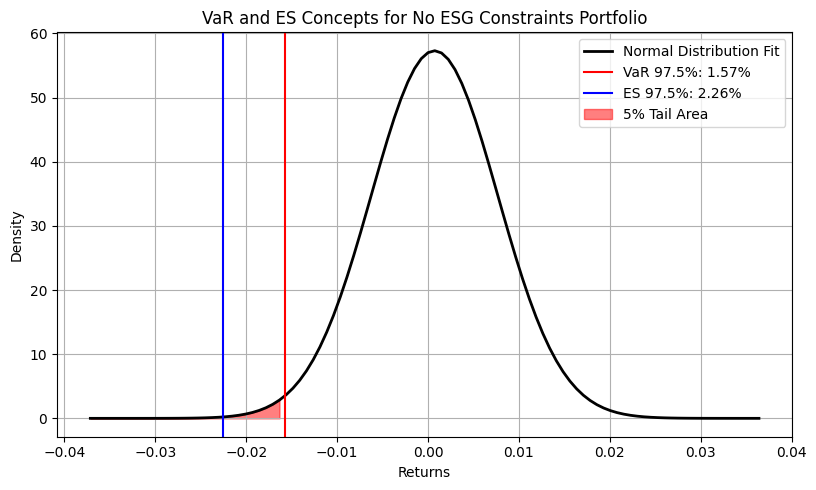

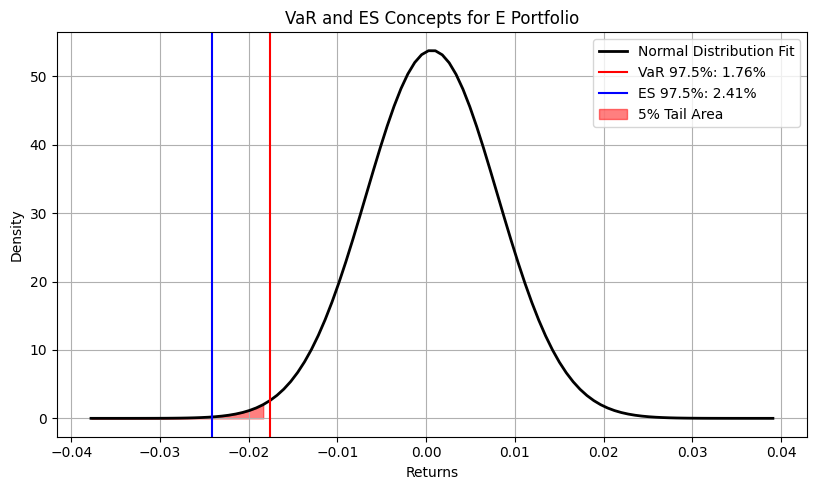

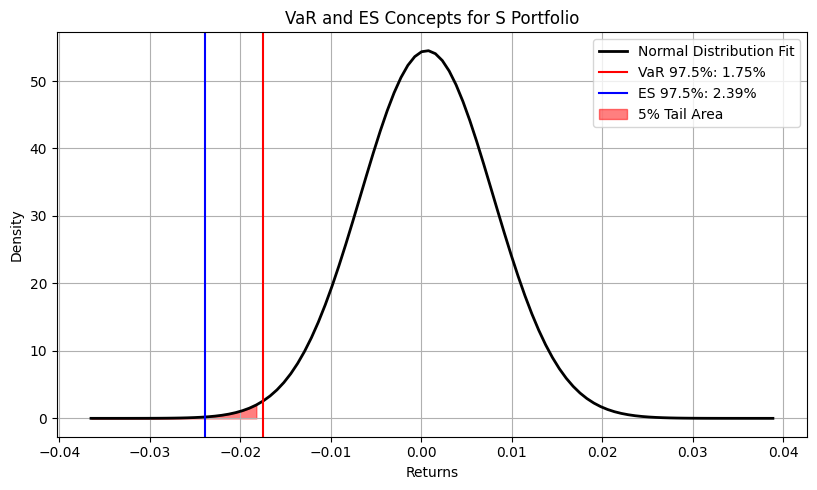

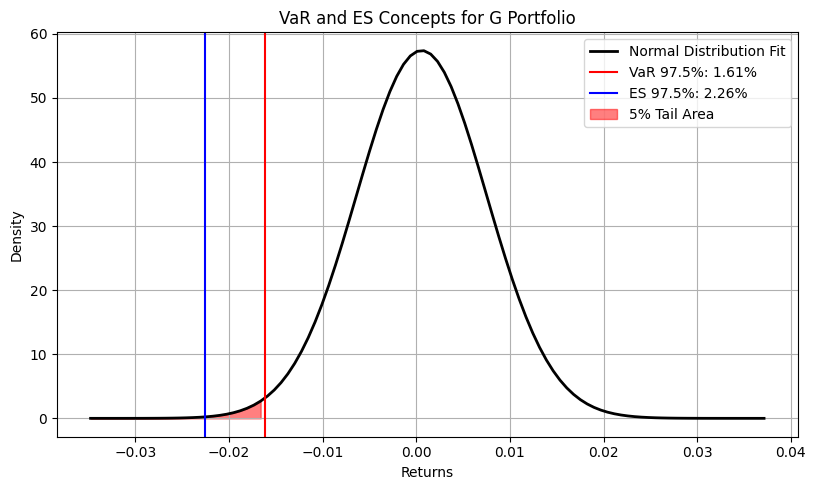

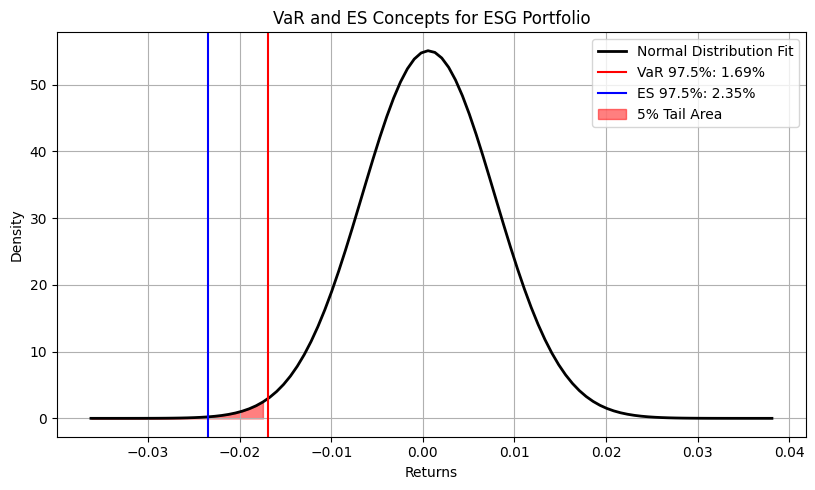

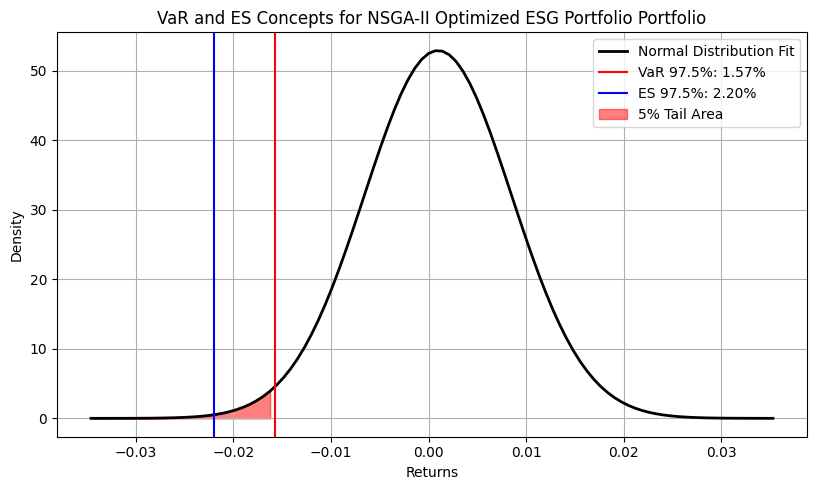

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Function to calculate VaR
def calculate_var(returns, confidence_level=0.975):
    return -np.percentile(returns, 100 * (1 - confidence_level))

# Function to calculate ES
def calculate_es(returns, confidence_level=0.975):
    var = calculate_var(returns, confidence_level)
    return -returns[returns <= -var].mean()

# Assuming conv_sh_rets, e_sh_rets, g_sh_rets, s_sh_rets, esg_sh_rets, nsga_ii_portfolio_returns, spy_portfolio_returns are loaded

# Dictionary of strategy names and their corresponding returns
strategies_returns = {
    'No ESG Constraints': conv_sh_rets,
    'E': e_sh_rets,
    'S': s_sh_rets,
    'G': g_sh_rets,
    'ESG': esg_sh_rets,
    'NSGA-II Optimized ESG Portfolio': nsga_ii_portfolio_returns,
}

# Loop through each strategy and plot the normal distribution with VaR and ES
for strategy_name, returns in strategies_returns.items():
    # Calculate VaR and ES
    var = calculate_var(returns)
    es = calculate_es(returns)

    # Fit a normal distribution to the data
    mu, std = norm.fit(returns)
    x_range = np.linspace(returns.min(), returns.max(), 100)
    pdf_values = norm.pdf(x_range, mu, std)

    # Plot the normal distribution fit
    plt.figure(figsize=(8.27, 5))  # Adjusted figure size for A4 page fitting
    plt.plot(x_range, pdf_values, color='k', linewidth=2, label='Normal Distribution Fit')

    # Mark VaR and ES on the plot
    plt.axvline(-var, color='r', linestyle='-', label=f'VaR 97.5%: {var*100:.2f}%')
    plt.axvline(-es, color='b', linestyle='-', label=f'ES 97.5%: {es*100:.2f}%')

    # Shade the 5% tail area
    mask = x_range < -var
    plt.fill_between(x_range, pdf_values, where=mask, color='red', alpha=0.5, label='5% Tail Area')

    plt.xlabel('Returns')
    plt.ylabel('Density')
    plt.title(f'VaR and ES Concepts for {strategy_name} Portfolio')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()  # Ensures everything fits within the plot area
    plt.show()
